# 说明
* 使用原始图片大小300,64训练
* 梳理网络结构，对比两个结构的差别
* 使用模型融合提高识别率

In [1]:
from pynvml import *

nvmlInit()
vram = nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(0)).free/1024.**2
print('GPU0 Memory: %dMB' % vram)
if vram < 8000:
    raise Exception('GPU Memory too low')

GPU0 Memory: 10458MB


# 导入必要的库

17


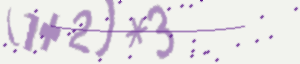

In [2]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from tqdm import tqdm
import pandas as pd
import cv2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
digits = string.digits
operators = '+-*'
characters = digits + operators + '()='
characters+='a'#CTC用 占位符

char_to_id = {j:i for i,j in enumerate(characters)}
id_to_char = {i:j for i,j in enumerate(characters)}
extra_char_id = char_to_id['a']

width, height, n_len, n_class = 300, 64, 11, len(characters)
print(n_class)

from IPython.display import display
generator = ImageCaptcha(width=width, height=height, font_sizes=range(35, 56), 
                         fonts=['fonts/%s'%x for x in os.listdir('fonts') if '.tt' in x])
display(generator.generate_image('(1+2)*3'))

In [3]:

extra_char_id = char_to_id['a']
print(extra_char_id)

16


# 数据集划分

In [4]:
from sklearn.model_selection import train_test_split
data_csv = pd.read_csv('G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train.csv')
img_dirpath = data_csv['filename'].tolist()
label = data_csv['label'].tolist()
X_data, X_valid, y_data, y_valid = train_test_split(img_dirpath, label, test_size=10000, random_state=17)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=10000, random_state=17)

In [5]:
print(len(img_dirpath))
print(len(X_train))
print(len(X_valid))
print(len(X_test))
print(X_train[0])
print(y_train[0])

100000
80000
10000
10000
train/18734.jpg
1*0*4=0


# 定义 CTC Loss

In [6]:
from keras import backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN tend to be garbage:
    # 由于我们使用的是循环神经网络，所以默认丢掉前面两个输出，因为它们通常无意义，且会影响模型的输出
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

Using TensorFlow backend.


In [7]:
from keras.layers import *
from keras.models import *
from make_parallel import make_parallel
rnn_size = 128

input_tensor = Input((width, height, 3))# (300,64,3)
x = input_tensor
# for i in range(3):
#     x = Conv2D(32*2**i, (3, 3), kernel_initializer='he_normal')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Conv2D(32*2**i, (3, 3), kernel_initializer='he_normal')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)

# VGG16 的结构
# 1
x = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x) # 模型有过拟合的倾向，加入dropout层
# 2
x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x) # 模型有过拟合的倾向，加入dropout层
# 3
x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x) # 模型有过拟合的倾向，加入dropout层

# CNN to RNN
conv_shape = x.get_shape()
x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x) #  Flatten

x = Dense(128, kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# RNN layer
gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', 
             name='gru1_b')(x)
gru1_merged = add([gru_1, gru_1b])
gru1_merged = BatchNormalization()(gru1_merged)

gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', 
             name='gru2_b')(gru1_merged)
x = concatenate([gru_2, gru_2b])
x = Dropout(0.25)(x)
x = Dense(n_class, kernel_initializer='he_normal', activation='softmax')(x)
# 预测
base_model = Model(input=input_tensor, output=x)

# base_model2 = make_parallel(base_model, 4)

labels = Input(name='the_labels', shape=[n_len], dtype='float32') # (None ,11)
input_length = Input(name='input_length', shape=(1,), dtype='int64')# (None, 1)？？？？
label_length = Input(name='label_length', shape=(1,), dtype='int64')# (None, 1)？？？？
# Keras doesn't currently support loss funcs with extra parameters so CTC loss is implemented in a lambda layer
loss_out = Lambda(ctc_lambda_func, name='ctc')([base_model.output, labels, input_length, label_length]) #(None, 1)

# 训练
model = Model(inputs=(input_tensor, labels, input_length, label_length), outputs=loss_out)

# 1.把目标当成一个输入，构成多输入模型，把loss写成一个层，作为最后的输出，搭建模型的时候，就只需要将模型的output定义为loss，
# 而compile的时候，直接将loss设置为y_pred（因为模型的输出就是loss，所以y_pred就是loss），无视y_true，
# 训练的时候，y_true随便扔一个符合形状的数组进去就行了
# 2.为了避免手动调参，我们使用了 Adam 优化器，它的学习率是自动设置的，我们只需要给一个较好的初始学习率即可
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')

d:\ProgramData\Anaconda3\envs\captcha_demo\lib\site-packages\ipykernel_launcher.py:68: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


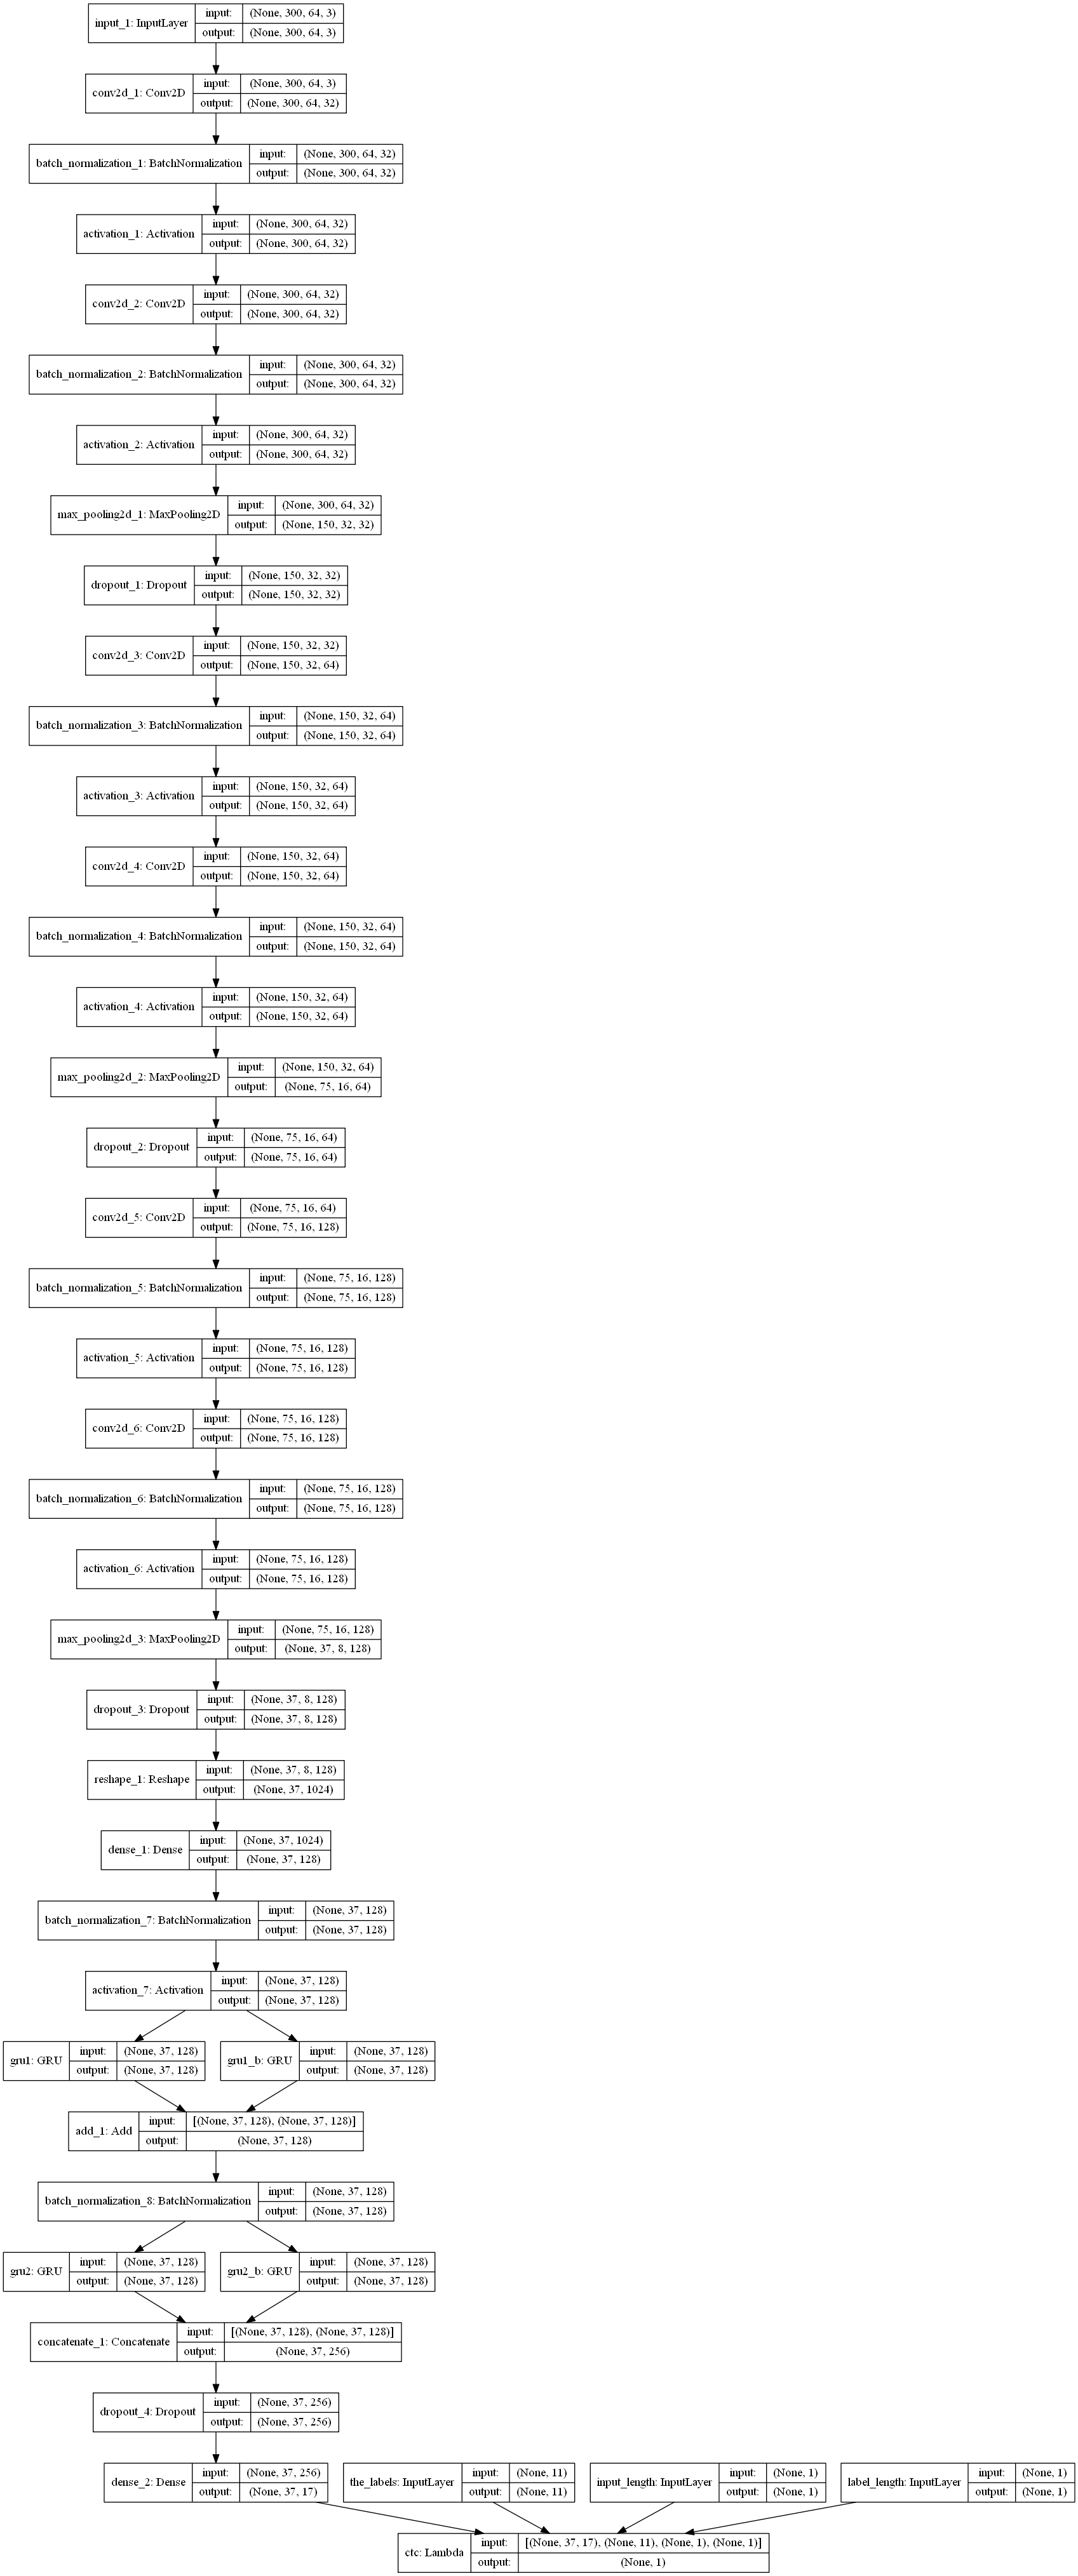

In [8]:
from IPython.display import Image
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

#plot(model, to_file="model.png", show_shapes=True)
Image('model.png')

# 绘制准确率

In [9]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'b-')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')
    plt.savefig("Training and validation accuracy.png")
    plt.figure()
    plt.plot(epochs, loss, 'b-')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.savefig("Training and validation loss.png")
    plt.show()

# 数据生成器定义

In [11]:
n_train = len(X_train)
print(n_train)
X_train_data = np.zeros((n_train, width, height, 3), dtype=np.uint8)
y_train_data = np.zeros((n_train, n_len), dtype=np.int32)
label_length_train = np.zeros((n_train, 1), dtype=np.int32)

for i,item in tqdm(enumerate(X_train)):
    img = cv2.imread('G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/%s'%item)
    
    # 输入的时候是经过了旋转的，这是因为我们希望以水平方向输入循环神经网络，
    # 而图片在 numpy 里默认是这样的形状：(height, width, 3)，因此我们使用了 transpose 函数将图片转为了(width, height, 3)的格式，
    # 这样就能把 X 轴转到第一个维度，方便输入到循环神经网络
    X_train_data[i] = img[:,:,::-1].transpose(1, 0, 2)#将图像逆时针旋转90度后，上下翻转
    random_str = y_train[i]
    y_train_data[i,:len(random_str)] = [char_to_id[x] for x in random_str]
    y_train_data[i,len(random_str):] = extra_char_id # 空白用占位字符
    label_length_train[i] = len(random_str)

80000


80000it [08:57, 148.80it/s] 


In [23]:
shuffle_indexes = list(range(len(X_train))) # 初始化为顺序
count = 0
def gen(batch_size=128):
    X = np.zeros((batch_size, width, height, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.int32)
    label_length = np.ones(batch_size)
    global count
    while True:
        for i in range(batch_size):
            index = batch_size*count + i
            # 如果超过
            if index >= len(X_train):
                count = 0
                random.shuffle(shuffle_indexes) # 超过最大数量后，打乱排序，再训练
                index = batch_size*count + i
            shuffle_index = shuffle_indexes[index]
            img_file_name = X_train[shuffle_index]
            tem_str = y_train[shuffle_index]
            
#             print('')
#             print(img_file_name)
#             print(tem_str)

#             img = cv2.imread('G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/%s'%img_file_name)
#             img = cv2.imread('G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/0.jpg')
#             print('G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/%s'%img_file_name)
            
            # 输入的时候是经过了旋转的，这是因为我们希望以水平方向输入循环神经网络，
            # 而图片在 numpy 里默认是这样的形状：(height, width, 3)，因此我们使用了 transpose 函数将图片转为了(width, height, 3)的格式，
            # 这样就能把 X 轴转到第一个维度，方便输入到循环神经网络
            X[i] = X_train_data[shuffle_index]
            y[i,:] = y_train_data[shuffle_index]
            
#             print('')
#             print(y[i,:])

            label_length[i] = label_length_train[shuffle_index]
#         print('')
#         print(count)
        count = count + 1
        yield [X, y, np.ones(batch_size)*int(conv_shape[1]-2), label_length], np.ones(batch_size)
#         yield [X, y, np.ones(batch_size)*int(conv_shape[1]), label_length], np.ones(batch_size)


In [13]:
[X_test111, y_test111, _111, label_length_test111], _ = next(gen(1))
print(''.join([id_to_char[x] for x in y_test111[0]]))


[ 1 12  0 12  4 15  0 16 16 16 16]
1*0*4=0aaaa


# 验证函数和回调函数

In [14]:
n_valid = len(X_valid)
print(n_valid)
X_valid_data = np.zeros((n_valid, width, height, 3), dtype=np.uint8)
y_valid_data = np.zeros((n_valid, n_len), dtype=np.int32)
label_length_valid = np.zeros((n_valid, 1), dtype=np.int32)

for i,item in tqdm(enumerate(X_valid)):
    img = cv2.imread('G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/%s'%item)
    
    # 输入的时候是经过了旋转的，这是因为我们希望以水平方向输入循环神经网络，
    # 而图片在 numpy 里默认是这样的形状：(height, width, 3)，因此我们使用了 transpose 函数将图片转为了(width, height, 3)的格式，
    # 这样就能把 X 轴转到第一个维度，方便输入到循环神经网络
    X_valid_data[i] = img[:,:,::-1].transpose(1, 0, 2)#将图像逆时针旋转90度后，上下翻转
    random_str = y_valid[i]
    y_valid_data[i,:len(random_str)] = [char_to_id[x] for x in random_str]
    y_valid_data[i,len(random_str):] = extra_char_id # 空白用占位字符
    label_length_valid[i] = len(random_str)

10000


10000it [00:22, 447.10it/s]


# 训练

In [39]:
from keras.optimizers import *
from keras.callbacks import *

batch_size = 128

try:
    model.load_weights('model_gru_best20190630.h5')
    print("...Previous weight data...")
except:
    print("...New weight data...")
    pass

#compile的时候，直接将loss设置为y_pred（因为模型的输出就是loss，所以y_pred就是loss），
#无视y_true，训练的时候，y_true随便扔一个符合形状的数组进去就行了
# model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(1e-3), metrics=['accuracy'])#lr先设成Adam(1e-3)快速试错，看能否收敛#optimizer=Adam(1e-4))
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adadelta(), metrics=['accuracy'])#lr先设成Adam(1e-3)快速试错，看能否收敛#optimizer=Adam(1e-4))
h = model.fit_generator(gen(batch_size), 
#                         workers=4,# workers=4 参数让 Keras 自动实现多进程生成数据，摆脱 python 单线程效率低的缺点
                        verbose = 2,
                        #use_multiprocessing=False,
                        validation_data=([X_valid_data, y_valid_data, np.ones(n_valid)*int(conv_shape[1]-2), label_length_valid], np.ones(n_valid)), 
                        steps_per_epoch=len(X_train)/batch_size, 
                        epochs=20, #调试只设1代，正常50到150
                        
                        # 为了避免手动调参，我们使用了 Adam 优化器，它的学习率是自动设置的，我们只需要给一个较好的初始学习率即可。
                        # EarlyStopping 是一个 Keras 的 Callback，它可以在 loss 超过多少个 epoch 没有下降以后，就自动终止训练，避免浪费时间。
                        # ModelCheckpoint 是另一个好用的 Callback，它可以保存训练过程中最好的模型。
                        # CSVLogger 可以记录 loss 为 CSV 文件，这样我们就可以在训练完成以后绘制训练过程中的 loss 曲线。
                        callbacks=[EarlyStopping(patience=3), CSVLogger('crnn20190630.csv'), ModelCheckpoint('model_gru_best20190630.h5', save_best_only=True, monitor='val_acc', verbose=0)]
#                         callbacks=[EarlyStopping(patience=3), CSVLogger('crnn20190630.csv'), ModelCheckpoint('model_gru_best20190630.h5', save_best_only=True, verbose=0)]
                       )

...Previous weight data...
Epoch 1/20
 - 282s - loss: 6.3710 - acc: 0.3714 - val_loss: 1.7559 - val_acc: 0.4136
Epoch 2/20
 - 282s - loss: 6.3162 - acc: 0.3855 - val_loss: 1.4359 - val_acc: 0.8115
Epoch 3/20
 - 283s - loss: 6.3907 - acc: 0.3775 - val_loss: 1.6424 - val_acc: 0.5326
Epoch 4/20
 - 282s - loss: 6.4237 - acc: 0.3446 - val_loss: 1.4752 - val_acc: 0.8002
Epoch 5/20
 - 279s - loss: 6.2883 - acc: 0.4069 - val_loss: 1.3588 - val_acc: 0.8659
Epoch 6/20
 - 282s - loss: 6.2324 - acc: 0.4289 - val_loss: 1.4193 - val_acc: 0.8370
Epoch 7/20
 - 279s - loss: 6.3118 - acc: 0.3996 - val_loss: 1.4057 - val_acc: 0.8580
Epoch 8/20
 - 281s - loss: 6.2513 - acc: 0.4226 - val_loss: 1.3582 - val_acc: 0.8772
Epoch 9/20
 - 276s - loss: 6.2164 - acc: 0.4364 - val_loss: 1.2900 - val_acc: 0.9107
Epoch 10/20
 - 276s - loss: 6.2427 - acc: 0.4350 - val_loss: 1.3636 - val_acc: 0.8566
Epoch 11/20
 - 275s - loss: 6.3093 - acc: 0.4091 - val_loss: 1.4480 - val_acc: 0.8049
Epoch 12/20
 - 277s - loss: 6.1657 -

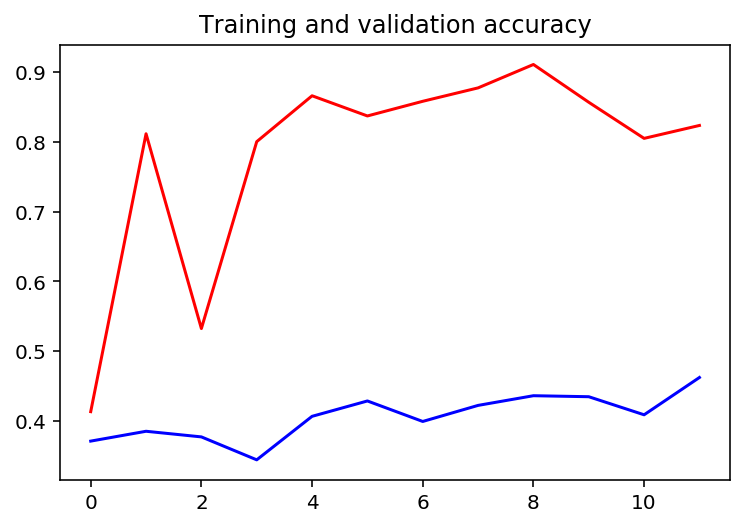

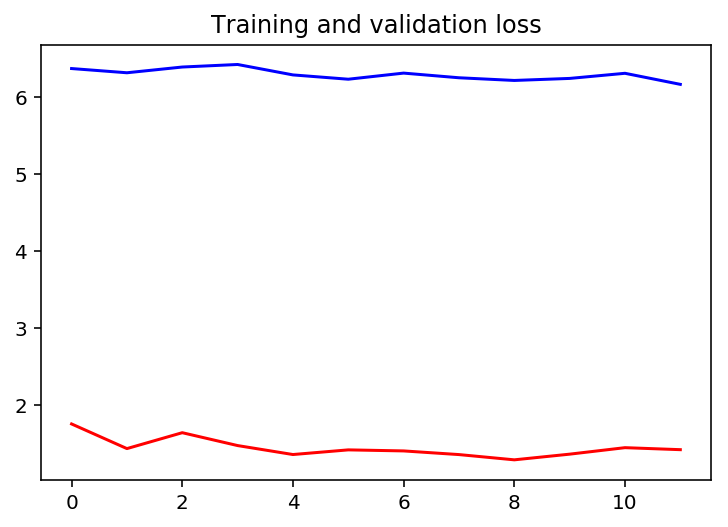

In [40]:
plot_training(h)

In [41]:
import itertools

def decode_label(out):
    out_best = list(np.argmax(out[0, 2:], axis=1))  # get max index
    out_best = [k for k, g in itertools.groupby(out_best)]  # remove overlap value
    outstr = ''.join([characters[x] for x in out_best if x > -1 and x < 16])
    return outstr

total = 0
acc = 0
letter_total = 0
letter_acc = 0
for i, img_file in tqdm(enumerate(X_test)):
    img = cv2.imread('G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/%s'%img_file)
    X = np.zeros((1, width, height, 3), dtype=np.uint8)
    X[0] = np.array(img[:,:,::-1]).transpose(1, 0, 2)
    net_out_value = base_model.predict(X)
    pred_texts = decode_label(net_out_value)
    for j in range(min(len(pred_texts), len(y_test[i]))):
        if pred_texts[j] == y_test[i][j]:
            letter_acc += 1
    letter_total += max(len(pred_texts), len(y_test[i]))

    if pred_texts == y_test[i]:
        acc += 1
    total += 1

print("ACC : ", acc / total)
print("letter ACC : ", letter_acc / letter_total)



0it [00:00, ?it/s]

4it [00:00, 36.80it/s]

8it [00:00, 36.49it/s]

12it [00:00, 36.99it/s]

16it [00:00, 36.83it/s]

20it [00:00, 36.87it/s]

24it [00:00, 36.32it/s]

28it [00:00, 36.66it/s]

32it [00:00, 37.11it/s]

36it [00:00, 37.37it/s]

40it [00:01, 37.30it/s]

44it [00:01, 36.21it/s]

48it [00:01, 36.09it/s]

52it [00:01, 36.89it/s]

56it [00:01, 36.94it/s]

60it [00:01, 36.59it/s]

64it [00:01, 36.85it/s]

68it [00:01, 36.98it/s]

72it [00:01, 36.93it/s]

76it [00:02, 36.98it/s]

80it [00:02, 37.22it/s]

84it [00:02, 36.99it/s]

88it [00:02, 37.19it/s]

92it [00:02, 37.80it/s]

96it [00:02, 37.92it/s]

100it [00:02, 37.47it/s]

104it [00:02, 37.79it/s]

108it [00:02, 36.77it/s]

112it [00:03, 37.29it/s]

116it [00:03, 37.66it/s]

120it [00:03, 37.29it/s]

124it [00:03, 37.67it/s]

128it [00:03, 37.20it/s]

132it [00:03, 36.87it/s]

136it [00:03, 37.47it/s]

140it [00:03, 37.90it/s]

144it [00:03, 37.71it/s]

148it [00:03, 37.22it/s]

152it [00:04, 36.37it/s]

156it [00:04, 36

1253it [00:33, 37.87it/s]

1257it [00:33, 37.91it/s]

1261it [00:33, 37.99it/s]

1265it [00:33, 38.21it/s]

1269it [00:33, 37.55it/s]

1273it [00:33, 37.74it/s]

1277it [00:33, 36.73it/s]

1281it [00:34, 36.45it/s]

1285it [00:34, 37.04it/s]

1289it [00:34, 37.59it/s]

1293it [00:34, 37.88it/s]

1297it [00:34, 37.34it/s]

1301it [00:34, 37.38it/s]

1305it [00:34, 37.20it/s]

1309it [00:34, 37.50it/s]

1313it [00:34, 37.49it/s]

1317it [00:35, 38.13it/s]

1321it [00:35, 38.48it/s]

1325it [00:35, 38.73it/s]

1329it [00:35, 38.57it/s]

1333it [00:35, 37.70it/s]

1337it [00:35, 37.21it/s]

1341it [00:35, 37.50it/s]

1345it [00:35, 37.08it/s]

1349it [00:35, 37.62it/s]

1353it [00:35, 38.22it/s]

1357it [00:36, 38.43it/s]

1361it [00:36, 38.14it/s]

1365it [00:36, 38.49it/s]

1369it [00:36, 38.07it/s]

1373it [00:36, 37.79it/s]

1377it [00:36, 37.70it/s]

1381it [00:36, 37.21it/s]

1385it [00:36, 37.40it/s]

1389it [00:36, 37.21it/s]

1393it [00:37, 37.72it/s]

1397it [00:37, 37.43it/s]

1

2465it [01:05, 38.42it/s]

2469it [01:05, 38.03it/s]

2473it [01:05, 37.75it/s]

2477it [01:06, 37.57it/s]

2481it [01:06, 37.02it/s]

2485it [01:06, 37.16it/s]

2489it [01:06, 37.05it/s]

2493it [01:06, 36.57it/s]

2497it [01:06, 37.46it/s]

2501it [01:06, 36.54it/s]

2505it [01:06, 36.42it/s]

2509it [01:06, 36.83it/s]

2513it [01:06, 37.03it/s]

2517it [01:07, 36.75it/s]

2521it [01:07, 37.28it/s]

2525it [01:07, 37.76it/s]

2529it [01:07, 37.87it/s]

2533it [01:07, 37.23it/s]

2537it [01:07, 37.41it/s]

2541it [01:07, 36.91it/s]

2545it [01:07, 36.14it/s]

2549it [01:07, 36.73it/s]

2553it [01:08, 37.06it/s]

2557it [01:08, 36.88it/s]

2561it [01:08, 36.90it/s]

2565it [01:08, 37.34it/s]

2569it [01:08, 37.31it/s]

2573it [01:08, 37.78it/s]

2577it [01:08, 36.66it/s]

2581it [01:08, 37.31it/s]

2585it [01:08, 37.16it/s]

2589it [01:09, 37.36it/s]

2593it [01:09, 36.93it/s]

2597it [01:09, 37.40it/s]

2601it [01:09, 37.12it/s]

2605it [01:09, 37.73it/s]

2609it [01:09, 38.06it/s]

2

3677it [01:38, 37.30it/s]

3681it [01:38, 36.94it/s]

3685it [01:38, 36.85it/s]

3689it [01:38, 37.45it/s]

3693it [01:38, 37.25it/s]

3697it [01:38, 36.21it/s]

3701it [01:38, 36.58it/s]

3705it [01:38, 37.05it/s]

3709it [01:38, 37.18it/s]

3713it [01:39, 37.27it/s]

3717it [01:39, 37.86it/s]

3721it [01:39, 37.33it/s]

3725it [01:39, 37.48it/s]

3729it [01:39, 37.59it/s]

3733it [01:39, 37.14it/s]

3737it [01:39, 37.24it/s]

3741it [01:39, 37.78it/s]

3745it [01:39, 36.59it/s]

3749it [01:40, 36.45it/s]

3753it [01:40, 36.96it/s]

3757it [01:40, 37.11it/s]

3761it [01:40, 37.22it/s]

3765it [01:40, 37.62it/s]

3769it [01:40, 37.68it/s]

3773it [01:40, 38.15it/s]

3777it [01:40, 38.50it/s]

3781it [01:40, 37.97it/s]

3785it [01:40, 37.61it/s]

3789it [01:41, 36.85it/s]

3793it [01:41, 37.45it/s]

3797it [01:41, 37.25it/s]

3801it [01:41, 37.01it/s]

3805it [01:41, 36.74it/s]

3809it [01:41, 37.48it/s]

3813it [01:41, 37.27it/s]

3817it [01:41, 37.02it/s]

3821it [01:41, 37.37it/s]

3

4889it [02:10, 37.29it/s]

4893it [02:10, 37.77it/s]

4897it [02:10, 37.58it/s]

4901it [02:10, 37.49it/s]

4905it [02:10, 37.76it/s]

4909it [02:11, 37.10it/s]

4913it [02:11, 37.52it/s]

4917it [02:11, 36.69it/s]

4921it [02:11, 36.12it/s]

4925it [02:11, 36.23it/s]

4929it [02:11, 36.80it/s]

4933it [02:11, 37.31it/s]

4937it [02:11, 36.54it/s]

4941it [02:11, 36.33it/s]

4945it [02:12, 36.37it/s]

4949it [02:12, 36.30it/s]

4953it [02:12, 36.70it/s]

4957it [02:12, 36.77it/s]

4961it [02:12, 37.19it/s]

4965it [02:12, 37.70it/s]

4969it [02:12, 37.11it/s]

4973it [02:12, 36.41it/s]

4977it [02:12, 36.72it/s]

4981it [02:13, 36.95it/s]

4985it [02:13, 36.90it/s]

4989it [02:13, 37.28it/s]

4993it [02:13, 37.51it/s]

4997it [02:13, 38.14it/s]

5001it [02:13, 38.49it/s]

5005it [02:13, 38.40it/s]

5009it [02:13, 38.12it/s]

5013it [02:13, 37.93it/s]

5017it [02:13, 38.22it/s]

5021it [02:14, 38.44it/s]

5025it [02:14, 37.40it/s]

5029it [02:14, 37.74it/s]

5033it [02:14, 37.35it/s]

5

6101it [02:42, 36.72it/s]

6105it [02:43, 37.05it/s]

6109it [02:43, 36.81it/s]

6113it [02:43, 37.53it/s]

6117it [02:43, 36.93it/s]

6121it [02:43, 37.15it/s]

6125it [02:43, 37.04it/s]

6129it [02:43, 35.88it/s]

6133it [02:43, 35.86it/s]

6137it [02:43, 36.53it/s]

6141it [02:44, 37.16it/s]

6145it [02:44, 37.15it/s]

6149it [02:44, 36.84it/s]

6153it [02:44, 36.93it/s]

6157it [02:44, 36.89it/s]

6161it [02:44, 36.86it/s]

6165it [02:44, 36.95it/s]

6169it [02:44, 37.10it/s]

6173it [02:44, 37.74it/s]

6177it [02:45, 36.73it/s]

6181it [02:45, 36.06it/s]

6185it [02:45, 35.79it/s]

6189it [02:45, 35.99it/s]

6193it [02:45, 36.62it/s]

6197it [02:45, 36.58it/s]

6201it [02:45, 36.24it/s]

6205it [02:45, 36.51it/s]

6209it [02:45, 36.39it/s]

6213it [02:46, 35.92it/s]

6217it [02:46, 36.18it/s]

6221it [02:46, 36.56it/s]

6225it [02:46, 36.93it/s]

6229it [02:46, 36.49it/s]

6233it [02:46, 36.20it/s]

6237it [02:46, 36.18it/s]

6241it [02:46, 36.76it/s]

6245it [02:46, 36.32it/s]

6

7313it [03:15, 37.26it/s]

7317it [03:15, 37.86it/s]

7321it [03:15, 38.07it/s]

7325it [03:15, 37.15it/s]

7329it [03:16, 37.04it/s]

7333it [03:16, 37.07it/s]

7337it [03:16, 37.51it/s]

7341it [03:16, 37.08it/s]

7345it [03:16, 37.41it/s]

7349it [03:16, 36.61it/s]

7353it [03:16, 37.49it/s]

7357it [03:16, 36.87it/s]

7361it [03:16, 36.74it/s]

7365it [03:16, 37.45it/s]

7369it [03:17, 37.67it/s]

7373it [03:17, 37.09it/s]

7377it [03:17, 37.00it/s]

7381it [03:17, 37.20it/s]

7385it [03:17, 36.48it/s]

7389it [03:17, 36.18it/s]

7393it [03:17, 36.26it/s]

7397it [03:17, 36.57it/s]

7401it [03:17, 37.46it/s]

7405it [03:18, 37.89it/s]

7409it [03:18, 37.50it/s]

7413it [03:18, 37.28it/s]

7417it [03:18, 37.24it/s]

7421it [03:18, 37.42it/s]

7425it [03:18, 37.13it/s]

7429it [03:18, 36.03it/s]

7433it [03:18, 36.25it/s]

7437it [03:18, 36.42it/s]

7441it [03:19, 36.13it/s]

7445it [03:19, 36.23it/s]

7449it [03:19, 37.00it/s]

7453it [03:19, 36.84it/s]

7457it [03:19, 36.82it/s]

7

8527it [03:48, 36.91it/s]

8531it [03:48, 37.18it/s]

8535it [03:48, 37.58it/s]

8539it [03:48, 38.09it/s]

8543it [03:48, 38.56it/s]

8547it [03:48, 38.34it/s]

8551it [03:48, 37.86it/s]

8555it [03:48, 37.54it/s]

8559it [03:49, 36.60it/s]

8563it [03:49, 36.75it/s]

8567it [03:49, 37.07it/s]

8571it [03:49, 36.98it/s]

8575it [03:49, 36.42it/s]

8579it [03:49, 36.24it/s]

8583it [03:49, 36.30it/s]

8587it [03:49, 35.48it/s]

8591it [03:49, 36.45it/s]

8595it [03:49, 37.17it/s]

8599it [03:50, 37.68it/s]

8603it [03:50, 37.52it/s]

8607it [03:50, 37.40it/s]

8611it [03:50, 37.64it/s]

8615it [03:50, 37.27it/s]

8619it [03:50, 37.13it/s]

8623it [03:50, 36.72it/s]

8627it [03:50, 37.57it/s]

8631it [03:50, 37.44it/s]

8635it [03:51, 37.14it/s]

8639it [03:51, 37.56it/s]

8643it [03:51, 37.75it/s]

8647it [03:51, 38.10it/s]

8651it [03:51, 38.29it/s]

8655it [03:51, 36.79it/s]

8659it [03:51, 37.40it/s]

8663it [03:51, 37.21it/s]

8667it [03:51, 37.29it/s]

8671it [03:52, 36.93it/s]

8

9739it [04:20, 37.17it/s]

9743it [04:20, 37.79it/s]

9747it [04:20, 37.91it/s]

9751it [04:20, 37.99it/s]

9755it [04:20, 38.05it/s]

9759it [04:21, 37.46it/s]

9763it [04:21, 37.47it/s]

9767it [04:21, 38.00it/s]

9771it [04:21, 38.38it/s]

9775it [04:21, 38.32it/s]

9779it [04:21, 38.40it/s]

9783it [04:21, 38.45it/s]

9787it [04:21, 37.83it/s]

9791it [04:21, 37.62it/s]

9795it [04:21, 37.37it/s]

9799it [04:22, 37.93it/s]

9803it [04:22, 38.34it/s]

9807it [04:22, 37.12it/s]

9811it [04:22, 37.65it/s]

9815it [04:22, 38.25it/s]

9819it [04:22, 38.23it/s]

9823it [04:22, 37.47it/s]

9827it [04:22, 36.96it/s]

9831it [04:22, 37.53it/s]

9835it [04:23, 38.16it/s]

9839it [04:23, 37.74it/s]

9843it [04:23, 38.31it/s]

9847it [04:23, 37.95it/s]

9851it [04:23, 38.02it/s]

9855it [04:23, 37.28it/s]

9859it [04:23, 37.55it/s]

9863it [04:23, 37.74it/s]

9867it [04:23, 36.63it/s]

9871it [04:23, 37.07it/s]

9875it [04:24, 37.51it/s]

9879it [04:24, 38.03it/s]

9883it [04:24, 37.65it/s]

9

ACC :  0.9721
letter ACC :  0.9949032946952434
